# Imports

In [ ]:
!git clone  https://github.com/avivabou/pal.git
%cd pal/projects/cot/notebooks
!ls

Cloning into 'pal'...
remote: Enumerating objects: 333, done.
remote: Counting objects: 100% (150/150), done.
remote: Compressing objects: 100% (112/112), done.
remote: Total 333 (delta 67), reused 78 (delta 37), pack-reused 183 (from 1)
Receiving objects: 100% (333/333), 5.17 MiB | 23.31 MiB/s, done.
Resolving deltas: 100% (109/109), done.
/content/pal/projects/cot/notebooks
bounded_output.ipynb  show_attention.ipynb  show_scaling.ipynb
replication.ipynb     show_dynamics.ipynb   show_scaling_pos.ipynb
replication_outputs   show_position.ipynb


In [ ]:
import sys, os
sys.path.append(os.path.abspath("/content/pal/src"))

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
from cot.models.transformer import Transformer, TransformerConfig
import seaborn as sns
from typing import List
from torch.nn.utils.rnn import pad_sequence
import random
from tqdm import trange
from copy import deepcopy

In [ ]:
# === Constants for tokenization / masking ===
# We reserve 0 for PAD everywhere.
PAD = 0

P = 11
DIGIT_OFFSET = 1  # digits -> 1..P
EOI = P + 1       # End-of-Iteration token id
VOCAB_SIZE = EOI + 1  # tokens: 0..EOI

print(f"PAD={PAD}, P={P}, EOI={EOI}, VOCAB_SIZE={VOCAB_SIZE}")

PAD=0, P=11, EOI=12, VOCAB_SIZE=13


# Hyper-params

In [ ]:
epochs = 1000
batch_size = 256
min_len = 8
max_len = 10
total_runs = 10

config = TransformerConfig(
    vocab_size=VOCAB_SIZE,
    emb_dim=128,
    n_head=1,
    seq_len=32,
    n_layer=2,
    norm="layer",
    norm_bias=True,
    weight_tying=True,
)



# Data

In [ ]:
class PolyCOTDataset(torch.utils.data.Dataset):
    def __init__(self, N=16384, seq_len=16, p=P, func=None, min_len=min_len):
        self.p = p
        self.func = (lambda x, y: (x * y + 1)) if func is None else func
        self.samples = []

        for _ in range(N):
            L = np.random.randint(min_len, seq_len + 1)
            x_raw = torch.randint(0, p, (L,))
            x_tok = x_raw + DIGIT_OFFSET


            states = torch.empty(L, dtype=torch.long)
            states[0] = (int(x_raw[0]) % p)
            for t in range(1, L):
                prev = int(states[t-1])
                curx = int(x_raw[t])
                states[t] = int(self.func(prev, curx)) % p

            s_tok = states + DIGIT_OFFSET

            inp = torch.cat([x_tok, torch.tensor([EOI])])
            inp_full = torch.cat([inp, s_tok[:-1]]) if L > 1 else inp

            tgt_full = torch.cat([torch.full((len(x_tok)+1,), PAD), s_tok])

            self.samples.append((inp_full, tgt_full))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]


In [ ]:
class ParityDataset(torch.utils.data.Dataset):
    def __init__(self, N=16384, seq_len=16):
        self.samples = []
        for _ in range(N):
            length = np.random.randint(2, seq_len + 1)
            bits = torch.randint(0, 2, (length,), dtype=torch.long)
            x_tok = bits + 1
            parity = torch.cumsum(bits, dim=0) % 2
            y_tok = parity + 1
            inp = torch.cat([x_tok, torch.tensor([EOI], dtype=torch.long)])
            inp_full = torch.cat([inp, y_tok[:-1]]) if length > 1 else inp
            tgt_full = torch.cat([torch.full((len(x_tok)+1,), PAD, dtype=torch.long), y_tok])
            self.samples.append((inp_full, tgt_full))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        x, y = self.samples[idx]
        return torch.tensor(x, dtype=torch.long), torch.tensor(y, dtype=torch.long)



In [ ]:
# Factorial
class FactorialCOTDataset(torch.utils.data.Dataset):
    def __init__(self, N=16384, seq_len=16, p=P, min_len=min_len, avoid_zero=True):
        self.p = p
        self.samples = []
        for _ in range(N):
            L = np.random.randint(min_len, seq_len + 1)
            if avoid_zero:
                x_raw = torch.randint(1, p, (L,), dtype=torch.long)
            else:
                x_raw = torch.randint(0, p, (L,), dtype=torch.long)
            x_tok = x_raw + DIGIT_OFFSET

            states = torch.empty(L, dtype=torch.long)
            states[0] = int(x_raw[0]) % p
            for t in range(1, L):
                states[t] = (int(states[t-1]) * int(x_raw[t])) % p
            s_tok = states + DIGIT_OFFSET

            inp      = torch.cat([x_tok, torch.tensor([EOI], dtype=torch.long)])
            inp_full = torch.cat([inp, s_tok[:-1]]) if L > 1 else inp
            tgt_full = torch.cat([torch.full((len(x_tok)+1,), PAD, dtype=torch.long), s_tok])
            self.samples.append((inp_full, tgt_full))

    def __len__(self): return len(self.samples)
    def __getitem__(self, idx): return self.samples[idx]


#  Fibonacci
class FibonacciCOTDataset(torch.utils.data.Dataset):
    def __init__(self, N=16384, seq_len=16, p=P, min_len=min_len):
        self.p = p
        self.samples = []
        for _ in range(N):
            L = np.random.randint(min_len, seq_len + 1)
            x_raw = torch.randint(0, p, (L,), dtype=torch.long)
            x_tok = x_raw + DIGIT_OFFSET

            states = torch.empty(L, dtype=torch.long)
            states[0] = int(x_raw[0]) % p
            if L >= 2:
                states[1] = int(x_raw[1]) % p
                for t in range(2, L):
                    states[t] = (int(states[t-1]) + int(states[t-2])) % p
            s_tok = states + DIGIT_OFFSET

            inp      = torch.cat([x_tok, torch.tensor([EOI], dtype=torch.long)])
            inp_full = torch.cat([inp, s_tok[:-1]]) if L > 1 else inp
            tgt_full = torch.cat([torch.full((len(x_tok)+1,), PAD, dtype=torch.long), s_tok])
            self.samples.append((inp_full, tgt_full))

    def __len__(self): return len(self.samples)
    def __getitem__(self, idx): return self.samples[idx]


In [ ]:
def collate_fn(batch):
    xs, ys = zip(*batch)
    xs = pad_sequence(xs, batch_first=True, padding_value=PAD)
    ys = pad_sequence(ys, batch_first=True, padding_value=PAD)

    # Trim to per-batch max non-PAD length so inputs contain no pads
    true_lengths = (xs != PAD).sum(dim=1)
    Lmax = int(true_lengths.max().item())
    xs = xs[:, :Lmax]
    ys = ys[:, :Lmax]

    return xs, ys


# Model Object

In [ ]:
class Trainer:
    all_accuracies = []

    def __init__(self, config, batch_size=64):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.config = config
        self.model = Transformer(config).to(self.device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=3e-4)
        self.criterion = nn.CrossEntropyLoss(ignore_index=PAD)
        self.batch_size = batch_size
        self.task_counter = {}
        self.accuracies = []
        self.static_index = len(Trainer.all_accuracies)
        self.dataset = None
        Trainer.all_accuracies.append([])
        self.all_accuracies_flat = []

    def reset_optimizer(self, lr=3e-4):
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)

    def train(self, task='polynomial', epochs=10):
        while len(Trainer.all_accuracies) <= self.static_index:
          Trainer.all_accuracies.append([])
        if task == 'polynomial':
            dataset = PolyCOTDataset()
            self.dataset = dataset
        elif task == 'parity':
            dataset = ParityDataset()
            self.dataset = dataset
        elif task == 'factorial':
            dataset = FactorialCOTDataset()
            self.dataset = dataset
        elif task == 'fibonacci':
            dataset = FibonacciCOTDataset()
            self.dataset = dataset
        else:
            raise ValueError("Unknown task")

        count = self.task_counter.get(task, 0) + 1
        self.task_counter[task] = count
        task_name = f"{task} {count}"

        loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True, collate_fn=collate_fn)
        accs = []

        pbar = trange(epochs)
        for epoch in pbar:
            self.model.train()
            total_loss = 0
            for x, y in loader:
                x, y = x.to(self.device), y.to(self.device)
                self.optimizer.zero_grad()
                logits = self.model(x)
                loss = self.criterion(logits.view(-1, logits.size(-1)), y.view(-1))
                loss.backward()
                self.optimizer.step()
                total_loss += loss.item()


            acc = self.evaluate(loader, verbose=False)
            accs.append(acc)
            avg_loss = total_loss / len(loader)
            pbar.set_description(f"Epoch {epoch} | Loss: {avg_loss:.4f} | Acc: {acc:.2%}")

        self.accuracies.append({
            "name": task_name,
            "accs": accs
        })

        self.all_accuracies_flat = [a for entry in self.accuracies for a in entry["accs"]]
        Trainer.all_accuracies[self.static_index] = self.all_accuracies_flat

    def evaluate(self, loader, verbose=True):
        self.model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for x, y in loader:
                x, y = x.to(self.device), y.to(self.device)
                logits = self.model(x)
                preds = torch.argmax(logits, dim=-1)
                keep = (y != PAD)
                correct += ((preds == y) & keep).sum().item()
                total   += keep.sum().item()
        acc = correct / total
        if verbose:
            print(f"Accuracy: {acc:.2%}")
        return acc

    def plot_accuracy(self, save_path):
        if not self.accuracies:
            print("No runs to plot.")
            return

        start_x = 0
        for entry in self.accuracies:
            name = entry["name"]
            accs = entry["accs"]
            x = list(range(start_x, start_x + len(accs)))
            plt.plot(x, accs, label=name)
            start_x += len(accs)

        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title("Accuracy Over Epochs")
        plt.legend()
        plt.grid()
        plt.savefig(save_path, dpi=200)
        plt.show()


    def plot_attentions_heatmap(self, save_path):
          # self.model.load_state_dict(deepcopy(self.model.state_dict()))
          self.model.eval()
          seq = self.dataset[-4000][0].unsqueeze(0).to(self.device)

          with torch.no_grad():
              logits, attentions = self.model(seq, verbose=True)

          attn0 = attentions[0, 0, 0].cpu()
          attn1 = attentions[1, 0, 0].cpu()

          fig, axes = plt.subplots(1, 2, figsize=(10, 5))
          im0 = axes[0].imshow(attn0, aspect='auto', origin='lower')
          im1 = axes[1].imshow(attn1, aspect='auto', origin='lower')
          axes[0].imshow(attn0)
          axes[1].imshow(attn1 > 0.5)

          axes[0].set_title("First attention map")
          axes[1].set_title("Second attention map")
          axes[0].set_xlabel("Key tokens")
          axes[1].set_xlabel("Key tokens")
          axes[0].set_ylabel("Query token")
          axes[0].set_yticks([])
          axes[1].yaxis.tick_right()

          fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)
          fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

          # 5) mark the EOI column
          eoi_pos = (seq[0] == EOI).nonzero(as_tuple=True)[0]
          if len(eoi_pos) > 0:
              eoi_pos = int(eoi_pos[0].item())
              for ax in axes:
                  ax.axvline(eoi_pos, color='white', linestyle='--', linewidth=1)

          plt.savefig(save_path,  bbox_inches="tight")
          plt.show()
          plt.close(fig)


    def fork(self):
        new_trainer = Trainer(self.config, batch_size=self.batch_size)
        new_trainer.model.load_state_dict(deepcopy(self.model.state_dict()))
        new_trainer.optimizer.load_state_dict(deepcopy(self.optimizer.state_dict()))
        new_trainer.criterion = deepcopy(self.criterion)
        new_trainer.task_counter = deepcopy(self.task_counter)
        new_trainer.accuracies = deepcopy(self.accuracies)

        while len(Trainer.all_accuracies) <= new_trainer.static_index:
            Trainer.all_accuracies.append([])

        Trainer.all_accuracies[new_trainer.static_index] = deepcopy(
            Trainer.all_accuracies[self.static_index]
        )

        return new_trainer

    @staticmethod
    def summarize_runs(save_path):
        # Filter out any empty lists
        valid_runs = [a for a in Trainer.all_accuracies if a]

        if not valid_runs:
            print("No valid runs to summarize.")
            return

        max_len = max(len(a) for a in valid_runs)
        padded = [a + [a[-1]] * (max_len - len(a)) for a in valid_runs]
        mean_acc = np.mean(padded, axis=0)
        std_acc = np.std(padded, axis=0)

        plt.plot(mean_acc, label="Mean Accuracy")
        plt.fill_between(range(max_len), mean_acc - std_acc, mean_acc + std_acc, alpha=0.3, label="±1 std")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title("Average Accuracy Over Runs")
        plt.legend()
        plt.grid(True)
        plt.savefig(save_path, dpi=200)
        plt.show()

In [ ]:
# Train

Epoch 199 | Loss: 0.0000 | Acc: 100.00%: 100%|██████████| 200/200 [05:40<00:00,  1.70s/it]


Accuracy: 100.00%
Factorial standalone acc: 1.0


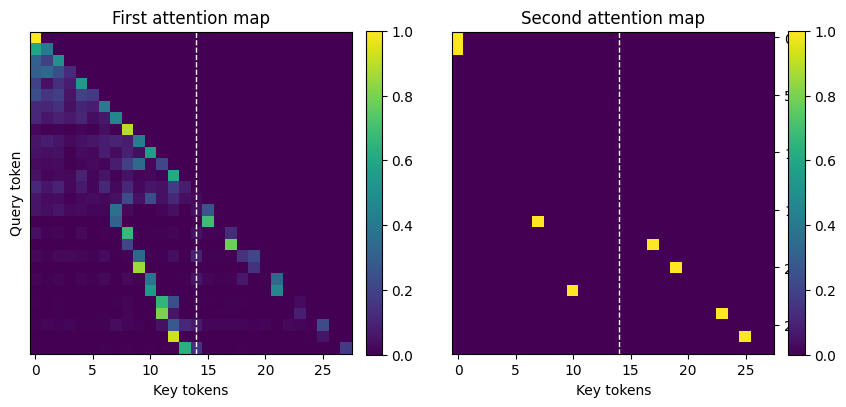

In [ ]:
# Factorial stand alone
# train
trainer = Trainer(config)
trainer.train(task='factorial', epochs=200)

# evaluate
fact_eval = DataLoader(FactorialCOTDataset(N=4096, seq_len=16, p=P, min_len=8, avoid_zero=True),
                       batch_size=256, shuffle=False, collate_fn=collate_fn)
trainer.dataset = fact_eval.dataset
print("Factorial standalone acc:", trainer.evaluate(fact_eval))

# attention map
trainer.plot_attentions_heatmap('/content/attn_factorial.png')


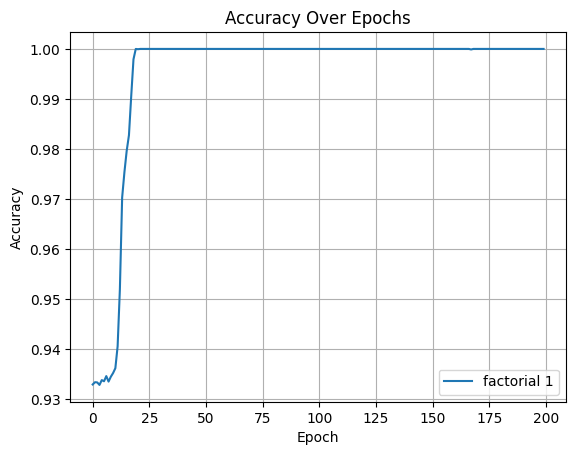

In [ ]:
trainer.plot_accuracy(save_path='/content/accuracy_factorial.png')

Epoch 199 | Loss: 0.0000 | Acc: 100.00%: 100%|██████████| 200/200 [05:50<00:00,  1.75s/it]


Accuracy: 100.00%
Fibonacci standalone acc: 1.0


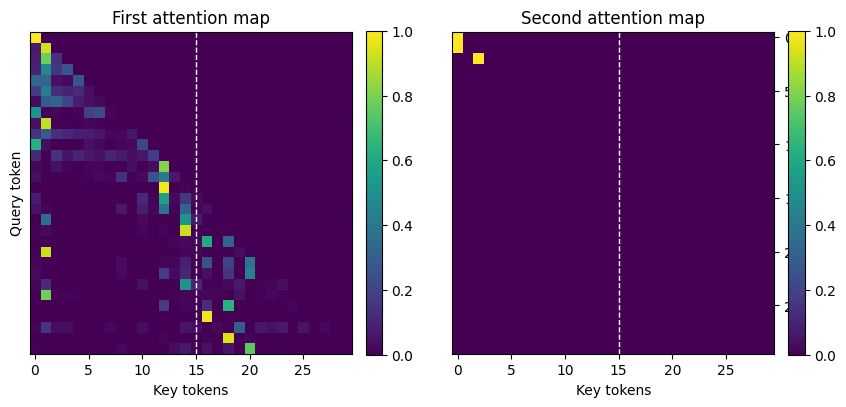

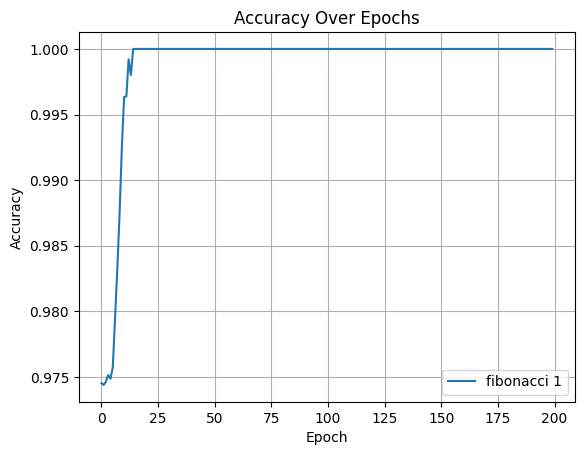

In [ ]:
# Fibonacci stand alone
# train
trainer = Trainer(config)
trainer.train(task='fibonacci', epochs=200)

# evaluate
fibo_eval = DataLoader(FibonacciCOTDataset(N=4096, seq_len=16, p=P, min_len=8),
                       batch_size=256, shuffle=False, collate_fn=collate_fn)
trainer.dataset = fibo_eval.dataset
print("Fibonacci standalone acc:", trainer.evaluate(fibo_eval))

#plots
trainer.plot_attentions_heatmap('/content/attn_fibonacci.png')

trainer.plot_accuracy(save_path='/content/accuracy_fibonacci.png')


Epoch 199 | Loss: 0.0000 | Acc: 100.00%: 100%|██████████| 200/200 [05:51<00:00,  1.76s/it]
Epoch 99 | Loss: 0.0000 | Acc: 100.00%: 100%|██████████| 100/100 [02:55<00:00,  1.76s/it]


Accuracy: 100.00%
Poly→Factorial transfer acc: 1.0


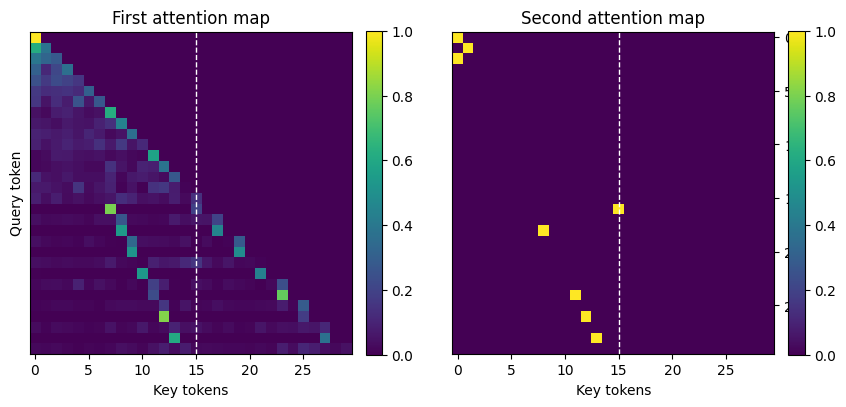

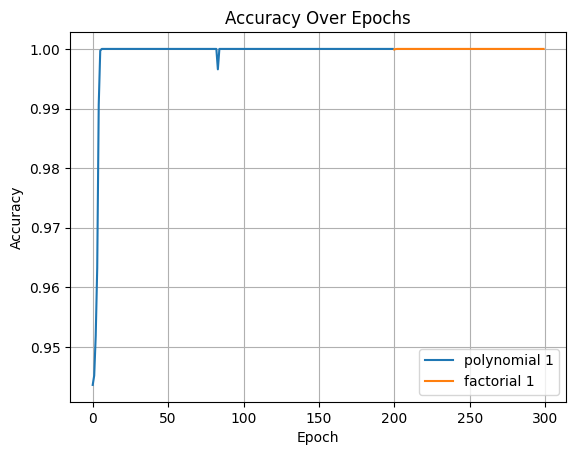

In [ ]:
# train on polynomial first 200 ephocs and than 100 epochs on factorial
trainer = Trainer(config)

# pretrain on polynomial
trainer.train(task='polynomial', epochs=200)

# transfer to factorial
trainer.reset_optimizer()
trainer.train(task='factorial', epochs=100)

# factorial eval
fact_eval = DataLoader(FactorialCOTDataset(N=4096, seq_len=16, p=P, min_len=8, avoid_zero=True),
                       batch_size=256, shuffle=False, collate_fn=collate_fn)
trainer.dataset = fact_eval.dataset
print("Poly→Factorial transfer acc:", trainer.evaluate(fact_eval))

# plots
trainer.plot_attentions_heatmap('/content/attn_factorial_after_poly.png')

trainer.plot_accuracy(save_path='/content/accuracy_factorial_after_poly.png')


Epoch 199 | Loss: 0.0000 | Acc: 100.00%: 100%|██████████| 200/200 [05:53<00:00,  1.77s/it]
Epoch 99 | Loss: 0.0000 | Acc: 100.00%: 100%|██████████| 100/100 [02:55<00:00,  1.75s/it]


Accuracy: 100.00%
Poly→Fibonacci transfer acc: 1.0


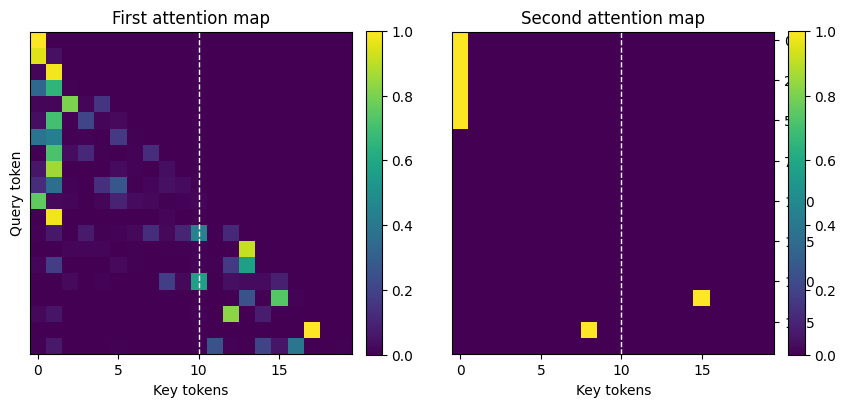

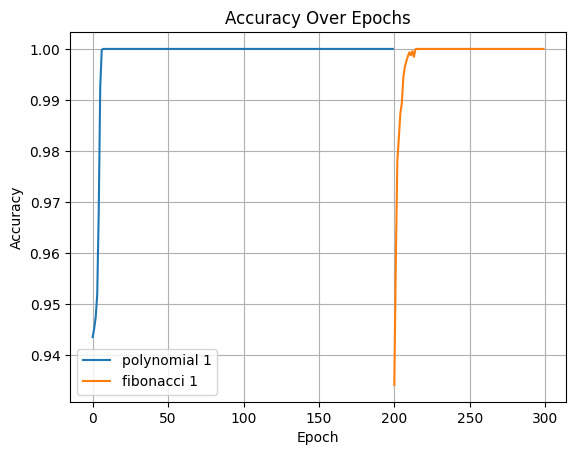

In [ ]:
# train on polynomial first 200 ephocs and than 100 ephocs on fibonacci

# pretrain on polynomial
trainer = Trainer(config)
trainer.train(task='polynomial', epochs=200)

# transfer to fibonacci
trainer.reset_optimizer(lr=3e-4)
trainer.train(task='fibonacci', epochs=100)

# fibonacci eval
fibo_eval = DataLoader(FibonacciCOTDataset(N=4096, seq_len=16, p=P, min_len=8),
                       batch_size=256, shuffle=False, collate_fn=collate_fn)
trainer.dataset = fibo_eval.dataset
print("Poly→Fibonacci transfer acc:", trainer.evaluate(fibo_eval))

#plots
trainer.plot_attentions_heatmap('/content/attn_fibonacci_after_poly.png')

trainer.plot_accuracy(save_path='/content/accuracy_fibonacci_after_poly.png')



Epoch 199 | Loss: 0.0000 | Acc: 100.00%: 100%|██████████| 200/200 [05:56<00:00,  1.78s/it]
Epoch 99 | Loss: 0.0000 | Acc: 100.00%: 100%|██████████| 100/100 [02:56<00:00,  1.76s/it]


Accuracy: 100.00%
fibonacci→Factorial transfer acc: 1.0


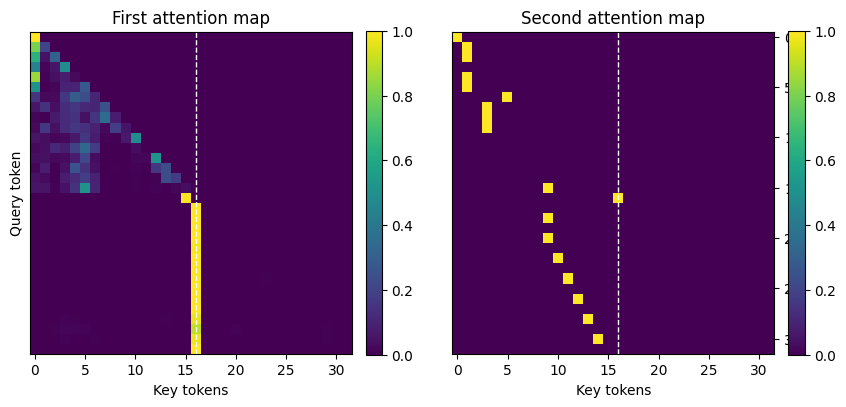

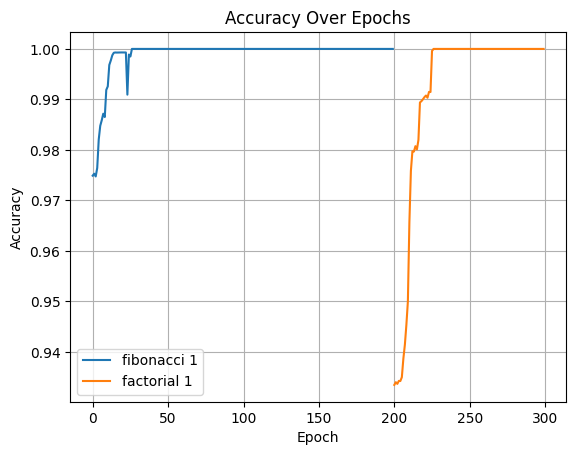

In [ ]:
# train on fibonacci first 200 ephocs and than 100 epochs on factorial
trainer = Trainer(config)

# pretrain on fibonacci
trainer.train(task='fibonacci', epochs=200)

# transfer to factorial
trainer.reset_optimizer()
trainer.train(task='factorial', epochs=100)

# factorial eval
fact_eval = DataLoader(FactorialCOTDataset(N=4096, seq_len=16, p=P, min_len=8, avoid_zero=True),
                       batch_size=256, shuffle=False, collate_fn=collate_fn)
trainer.dataset = fact_eval.dataset
print("fibonacci→Factorial transfer acc:", trainer.evaluate(fact_eval))

#plots
trainer.plot_attentions_heatmap('/content/attn_factorial_after_fibonacci.png')

trainer.plot_accuracy(save_path='/content/accuracy_factorial_after_fibonacci.png')